In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"

In [ ]:
!unzip -q dataset.zip
!unzip -q dataset/converted.zip
!unzip -q dataset/test9classes.zip

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math



class SeparableConvolution(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.dwc = nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size, stride, padding, dilation, groups=input_channel, bias=bias),
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, 1, 1, bias=bias)
        )
    
    def forward(self, X):
        return self.dwc(X)

class Block(nn.Module):
    def __init__(self, input_channel, out_channel, reps, strides=1, relu=True, grow_first=True):
        super().__init__()
        if out_channel != input_channel or strides!=1:
            self.skipConnections = nn.Sequential(
                nn.Conv2d(input_channel, out_channel, 1, stride=strides, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.skipConnections = None
        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = input_channel
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConvolution(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))
            filters = out_channel
        
        for _ in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConvolution(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConvolution(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))

        if not relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, input):
        X = self.rep(input)

        if self.skipConnections:
            skip = self.skipConnections(input)
        else:
            skip = input
        
        X += skip
        return X

class Xception(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.relu = nn.ReLU(inplace=True)

        self.initBlock = nn.Sequential(
            nn.Conv2d(input_channel, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.block1=Block(64,128,2,2,relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,relu=True,grow_first=False)

        self.convolution3 = SeparableConvolution(1024,1536,3,1,1)
        self.batchnorm3 = nn.BatchNorm2d(1536)

        #do relu here
        self.convolution4 = SeparableConvolution(1536,2048,3,1,1)
        self.batchnorm4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, self.n_classes)

        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.initBlock(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.convolution3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        
        x = self.convolution4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function

def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
with open('test9classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']
4050
4050


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # We use a small batch size here for training
batch_size_test = 5 #
batch_size_val = 5

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('converted/', val_files, val_classes, 
                         transforms=image_transform)
test_dataset = Hist('test9classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: STR


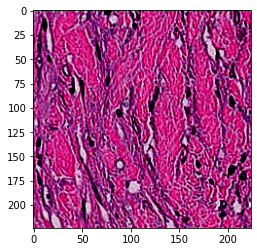

In [ ]:
# import library
import matplotlib.pyplot as plt
# Checking the data loader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# showing random image from dataloader
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 30
accuracy_test=[]

for i in range(5):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=9).to(device)
  learning_rate = 0.0005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("Xception9SGD.pth"):
        os.remove("Xception9SGD.pth")
      torch.save(model.state_dict(), 'Xception9SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Xception(input_channel=3, n_classes=9).to(device)
  model.load_state_dict(torch.load('Xception9SGD.pth', map_location=device))
  model=model.to(device)
  
  l,a=test(model, device, test_loader)
  accuracy_test.append(a)
print(accuracy_test)

Experiment:  1
1


<ipython-input-11-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.9357

Test: Average loss: 0.4677, Accuracy: 4516/5400 (83.63%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5597

Test: Average loss: 0.5141, Accuracy: 4450/5400 (82.41%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4315

Test: Average loss: 0.2390, Accuracy: 4958/5400 (91.81%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3631

Test: Average loss: 0.3536, Accuracy: 4763/5400 (88.20%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2905

Test: Average loss: 0.2817, Accuracy: 4871/5400 (90.20%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2553

Test: Average loss: 0.1846, Accuracy: 5055/5400 (93.61%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2236

Test: Average loss: 0.1857, Accuracy: 5066/5400 (93.81%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2019

Test: Average loss: 0.1475, Accuracy: 5113/5400 (94.69%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1757

Test: Average loss: 0.1710, Accuracy: 5092/5400 (94.30%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1628

Test: Average loss: 0.1433, Accuracy: 5135/5400 (95.09%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1480

Test: Average loss: 0.1329, Accuracy: 5160/5400 (95.56%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1387

Test: Average loss: 0.1076, Accuracy: 5213/5400 (96.54%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1306

Test: Average loss: 0.1653, Accuracy: 5088/5400 (94.22%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1224

Test: Average loss: 0.1274, Accuracy: 5145/5400 (95.28%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0940

Test: Average loss: 0.0978, Accuracy: 5192/5400 (96.15%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1004

Test: Average loss: 0.0793, Accuracy: 5258/5400 (97.37%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0872

Test: Average loss: 0.0848, Accuracy: 5252/5400 (97.26%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0777

Test: Average loss: 0.0830, Accuracy: 5262/5400 (97.44%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0750

Test: Average loss: 0.0879, Accuracy: 5247/5400 (97.17%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0660

Test: Average loss: 0.1698, Accuracy: 5078/5400 (94.04%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0684

Test: Average loss: 0.0963, Accuracy: 5231/5400 (96.87%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0602

Test: Average loss: 0.0628, Accuracy: 5287/5400 (97.91%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0649

Test: Average loss: 0.0671, Accuracy: 5267/5400 (97.54%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0611

Test: Average loss: 0.0813, Accuracy: 5254/5400 (97.30%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0518

Test: Average loss: 0.0804, Accuracy: 5266/5400 (97.52%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0412

Test: Average loss: 0.1102, Accuracy: 5213/5400 (96.54%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0362

Test: Average loss: 0.0755, Accuracy: 5275/5400 (97.69%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0391

Test: Average loss: 0.1644, Accuracy: 5136/5400 (95.11%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0471

Test: Average loss: 0.0807, Accuracy: 5259/5400 (97.39%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0374

Test: Average loss: 0.0717, Accuracy: 5274/5400 (97.67%)

Test: Average loss: 0.0929, Accuracy: 3940/4050 (97.28%)

Experiment:  2
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.9377

Test: Average loss: 0.5471, Accuracy: 4411/5400 (81.69%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5551

Test: Average loss: 0.5372, Accuracy: 4364/5400 (80.81%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4347

Test: Average loss: 0.2198, Accuracy: 4988/5400 (92.37%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3418

Test: Average loss: 0.2613, Accuracy: 4903/5400 (90.80%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2961

Test: Average loss: 0.2139, Accuracy: 5012/5400 (92.81%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2593

Test: Average loss: 0.2293, Accuracy: 4983/5400 (92.28%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2257

Test: Average loss: 0.1405, Accuracy: 5164/5400 (95.63%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1949

Test: Average loss: 0.1611, Accuracy: 5112/5400 (94.67%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1821

Test: Average loss: 0.1263, Accuracy: 5172/5400 (95.78%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1607

Test: Average loss: 0.1513, Accuracy: 5130/5400 (95.00%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1342

Test: Average loss: 0.1283, Accuracy: 5186/5400 (96.04%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1350

Test: Average loss: 0.1249, Accuracy: 5186/5400 (96.04%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1288

Test: Average loss: 0.1217, Accuracy: 5163/5400 (95.61%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1179

Test: Average loss: 0.0847, Accuracy: 5240/5400 (97.04%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0988

Test: Average loss: 0.0926, Accuracy: 5245/5400 (97.13%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1004

Test: Average loss: 0.0931, Accuracy: 5217/5400 (96.61%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0936

Test: Average loss: 0.1122, Accuracy: 5200/5400 (96.30%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0800

Test: Average loss: 0.0822, Accuracy: 5252/5400 (97.26%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0764

Test: Average loss: 0.0899, Accuracy: 5249/5400 (97.20%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0746

Test: Average loss: 0.0994, Accuracy: 5236/5400 (96.96%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0658

Test: Average loss: 0.0790, Accuracy: 5274/5400 (97.67%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0661

Test: Average loss: 0.0733, Accuracy: 5268/5400 (97.56%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0577

Test: Average loss: 0.0785, Accuracy: 5263/5400 (97.46%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0571

Test: Average loss: 0.0799, Accuracy: 5268/5400 (97.56%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0529

Test: Average loss: 0.0852, Accuracy: 5224/5400 (96.74%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0532

Test: Average loss: 0.0822, Accuracy: 5248/5400 (97.19%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0520

Test: Average loss: 0.0842, Accuracy: 5267/5400 (97.54%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0580

Test: Average loss: 0.0664, Accuracy: 5281/5400 (97.80%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0450

Test: Average loss: 0.0941, Accuracy: 5234/5400 (96.93%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0399

Test: Average loss: 0.0630, Accuracy: 5296/5400 (98.07%)

Test: Average loss: 0.0878, Accuracy: 3948/4050 (97.48%)

Experiment:  3
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.9667

Test: Average loss: 0.4871, Accuracy: 4466/5400 (82.70%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5933

Test: Average loss: 0.3867, Accuracy: 4722/5400 (87.44%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4513

Test: Average loss: 0.2756, Accuracy: 4886/5400 (90.48%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3608

Test: Average loss: 0.2449, Accuracy: 4941/5400 (91.50%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3080

Test: Average loss: 0.2467, Accuracy: 4942/5400 (91.52%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2649

Test: Average loss: 0.2121, Accuracy: 4994/5400 (92.48%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2227

Test: Average loss: 0.1529, Accuracy: 5122/5400 (94.85%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2004

Test: Average loss: 0.1610, Accuracy: 5125/5400 (94.91%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1877

Test: Average loss: 0.1277, Accuracy: 5162/5400 (95.59%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1623

Test: Average loss: 0.1311, Accuracy: 5162/5400 (95.59%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1499

Test: Average loss: 0.1071, Accuracy: 5209/5400 (96.46%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1332

Test: Average loss: 0.1261, Accuracy: 5177/5400 (95.87%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1371

Test: Average loss: 0.1103, Accuracy: 5205/5400 (96.39%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1136

Test: Average loss: 0.1172, Accuracy: 5189/5400 (96.09%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1064

Test: Average loss: 0.1367, Accuracy: 5165/5400 (95.65%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0960

Test: Average loss: 0.0895, Accuracy: 5248/5400 (97.19%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0865

Test: Average loss: 0.1061, Accuracy: 5196/5400 (96.22%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0828

Test: Average loss: 0.1137, Accuracy: 5202/5400 (96.33%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0769

Test: Average loss: 0.0990, Accuracy: 5199/5400 (96.28%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0728

Test: Average loss: 0.0831, Accuracy: 5257/5400 (97.35%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0730

Test: Average loss: 0.1652, Accuracy: 5131/5400 (95.02%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0616

Test: Average loss: 0.0998, Accuracy: 5220/5400 (96.67%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0596

Test: Average loss: 0.0900, Accuracy: 5241/5400 (97.06%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0536

Test: Average loss: 0.1025, Accuracy: 5224/5400 (96.74%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0454

Test: Average loss: 0.0680, Accuracy: 5282/5400 (97.81%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0448

Test: Average loss: 0.0767, Accuracy: 5271/5400 (97.61%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0388

Test: Average loss: 0.0922, Accuracy: 5230/5400 (96.85%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0431

Test: Average loss: 0.0974, Accuracy: 5241/5400 (97.06%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0348

Test: Average loss: 0.0655, Accuracy: 5282/5400 (97.81%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0414

Test: Average loss: 0.0950, Accuracy: 5239/5400 (97.02%)

Test: Average loss: 0.0739, Accuracy: 3950/4050 (97.53%)

Experiment:  4
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.9382

Test: Average loss: 0.5248, Accuracy: 4366/5400 (80.85%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5796

Test: Average loss: 0.5596, Accuracy: 4301/5400 (79.65%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4348

Test: Average loss: 0.3765, Accuracy: 4687/5400 (86.80%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3641

Test: Average loss: 0.2751, Accuracy: 4885/5400 (90.46%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3035

Test: Average loss: 0.2674, Accuracy: 4896/5400 (90.67%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2530

Test: Average loss: 0.2445, Accuracy: 4957/5400 (91.80%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2308

Test: Average loss: 0.1298, Accuracy: 5167/5400 (95.69%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1952

Test: Average loss: 0.1383, Accuracy: 5170/5400 (95.74%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1873

Test: Average loss: 0.1555, Accuracy: 5120/5400 (94.81%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1610

Test: Average loss: 0.1824, Accuracy: 5047/5400 (93.46%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1499

Test: Average loss: 0.0910, Accuracy: 5234/5400 (96.93%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1422

Test: Average loss: 0.0976, Accuracy: 5226/5400 (96.78%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1220

Test: Average loss: 0.1212, Accuracy: 5164/5400 (95.63%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1232

Test: Average loss: 0.1339, Accuracy: 5143/5400 (95.24%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1031

Test: Average loss: 0.1018, Accuracy: 5209/5400 (96.46%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0939

Test: Average loss: 0.1076, Accuracy: 5201/5400 (96.31%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0885

Test: Average loss: 0.0882, Accuracy: 5248/5400 (97.19%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0841

Test: Average loss: 0.1426, Accuracy: 5144/5400 (95.26%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0792

Test: Average loss: 0.1221, Accuracy: 5190/5400 (96.11%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0654

Test: Average loss: 0.0880, Accuracy: 5230/5400 (96.85%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0662

Test: Average loss: 0.1060, Accuracy: 5205/5400 (96.39%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0633

Test: Average loss: 0.1051, Accuracy: 5218/5400 (96.63%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0570

Test: Average loss: 0.0965, Accuracy: 5224/5400 (96.74%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0563

Test: Average loss: 0.0885, Accuracy: 5251/5400 (97.24%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0451

Test: Average loss: 0.0982, Accuracy: 5226/5400 (96.78%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0502

Test: Average loss: 0.0955, Accuracy: 5232/5400 (96.89%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0427

Test: Average loss: 0.0949, Accuracy: 5237/5400 (96.98%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0439

Test: Average loss: 0.0853, Accuracy: 5250/5400 (97.22%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0465

Test: Average loss: 0.1448, Accuracy: 5155/5400 (95.46%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0372

Test: Average loss: 0.0759, Accuracy: 5269/5400 (97.57%)

Test: Average loss: 0.1090, Accuracy: 3935/4050 (97.16%)

Experiment:  5
1


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8977

Test: Average loss: 0.6114, Accuracy: 4232/5400 (78.37%)

2


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.5530

Test: Average loss: 0.4377, Accuracy: 4605/5400 (85.28%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4187

Test: Average loss: 0.3577, Accuracy: 4759/5400 (88.13%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3524

Test: Average loss: 0.2449, Accuracy: 4970/5400 (92.04%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2883

Test: Average loss: 0.2753, Accuracy: 4918/5400 (91.07%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2541

Test: Average loss: 0.1746, Accuracy: 5063/5400 (93.76%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2243

Test: Average loss: 0.1872, Accuracy: 5065/5400 (93.80%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2101

Test: Average loss: 0.2015, Accuracy: 5064/5400 (93.78%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1770

Test: Average loss: 0.1332, Accuracy: 5152/5400 (95.41%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1607

Test: Average loss: 0.2383, Accuracy: 4964/5400 (91.93%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1492

Test: Average loss: 0.1868, Accuracy: 5059/5400 (93.69%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1359

Test: Average loss: 0.1137, Accuracy: 5199/5400 (96.28%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1281

Test: Average loss: 0.1283, Accuracy: 5158/5400 (95.52%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1128

Test: Average loss: 0.1011, Accuracy: 5227/5400 (96.80%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1077

Test: Average loss: 0.1928, Accuracy: 5057/5400 (93.65%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1002

Test: Average loss: 0.0980, Accuracy: 5232/5400 (96.89%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0875

Test: Average loss: 0.1191, Accuracy: 5197/5400 (96.24%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0874

Test: Average loss: 0.1119, Accuracy: 5215/5400 (96.57%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0770

Test: Average loss: 0.1312, Accuracy: 5181/5400 (95.94%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0777

Test: Average loss: 0.1206, Accuracy: 5175/5400 (95.83%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0674

Test: Average loss: 0.1216, Accuracy: 5176/5400 (95.85%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0588

Test: Average loss: 0.1004, Accuracy: 5231/5400 (96.87%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0536

Test: Average loss: 0.0852, Accuracy: 5255/5400 (97.31%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0604

Test: Average loss: 0.0768, Accuracy: 5271/5400 (97.61%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0561

Test: Average loss: 0.0836, Accuracy: 5250/5400 (97.22%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0438

Test: Average loss: 0.0886, Accuracy: 5238/5400 (97.00%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0503

Test: Average loss: 0.0641, Accuracy: 5293/5400 (98.02%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0432

Test: Average loss: 0.0859, Accuracy: 5268/5400 (97.56%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0453

Test: Average loss: 0.0529, Accuracy: 5308/5400 (98.30%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0349

Test: Average loss: 0.0667, Accuracy: 5292/5400 (98.00%)

Test: Average loss: 0.0681, Accuracy: 3975/4050 (98.15%)

[97.28395061728395, 97.48148148148148, 97.53086419753086, 97.1604938271605, 98.14814814814815]


In [1]:
import numpy as np
acc=np.array([97.28395061728395, 97.48148148148148, 97.53086419753086, 97.1604938271605, 98.14814814814815])
print(np.mean(acc))
print(np.std(acc))

97.52098765432099
0.34091961667344783
